# Computer visie

Deze notebook staat in het teken van computer visie.
Dit deel van Machine Learning is tegenwoordig heel populair en behaalt door middel van Deep Learning neurale netwerken heel goede resultaten bij het interpreteren van beelden en video.
De toepassingen van Computer visie zijn omvangrijk, bijvoorbeeld:
* Medische wereld: interpreteren scans, robots om te helpen bij kinesie therapie
* Mobiliteit: Zelfrijdende auto's
* Productie: Magazijnen waar robots zelf items halen of kijken hoe ze iets in elkaar moeten steken
* Gaming: Geavanceerde bots
* Media: Maken en detecteren van deep fakes/misinformatie

In deze domeinen wordt computervisie gebruikt zowel als regressie en classificatie techniek. 
Andere problemen die met computervisie opgelost kunnen worden zijn bijvoorbeeld object detection of image segmentation.
Deze technieken worden later in de leermodule bestudeerd.

## CNN

Op basis van de leerstof van de vorige module gebruik je meerdere dense-layers om een neuraal netwerk te maken voor regressie of classificatie..
Computer visie is echter een complex probleem waar het onvoldoende is om individuele pixelwaarden te weten voor een goede classificatie uit te voeren.
Indien je dit toch met een klassiek fully-connected neuraal netwerk te doen zou je heel veel neuronen, gewichten en lagen moeten hebben om deze verbanden goed te capteren.

De state-of-the-art neurale netwerken binnen computer visie plaatsen eerst een aantal lagen voor het neurale netwerken waarbij deze features geextraheerd worden.

Deze neurale netwerken worden Convolutionele Neurale Netwerken genoemd (CNN).
De naam hiervan komt voort uit het feit dat ze gebruik maken van Convolutionele lagen.
Naast deze convolutionele lagen wordt er ook vaak gebruik gemaakt van Pooling lagen om de dimensies te reduceren en zo de performantie te verbeteren.

Een goede uitleg met grafische steuntjes kan je vinden op [deze pagina](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

### Convolutionele lagen

De basis van een convolutionele laag is het concept van een convolutie.
Een convolutie is een mathematische operatie waarbij data uit verschillende bronnen wordt verbonden/samengevoegd.
In beeldverwerking wordt dit al lang gebruikt om bijvoorbeeld een blur-effect te introduceren, ruis te verminderen of randen scherper te maken. 

In neurale netwerken worden convolutionele lagen gebruikt om randen te detecteren.
In de eerste laag zijn dit letterlijk de randen/lijnen van de figuur maar dieper liggende lagen detecteren hogere orde features zoals gezichten, banden, ogen, ...

Deze convolutie/feature extraction wordt uitgevoerd door een kernel. Dit is een kleine matrix die een aantal pixelwaarden samenvoegd met bepaalde gewichten. Deze gewichten worden getrained.
Let wel op dat dezelfde kernel gebruikt wordt voor een hele feature-map. Hierdoor wordt het aantal gewichten beperkt.
Elke laag bestaat uit meerdere van deze kernels die elk een andere feature leren extraheren.

Bij het opstellen van een convolutionele laag moet je een aantal zaken kiezen. Deze keuzes bepalen de dimensies van de outputlaag en de structuur van de onderliggende lagen dus je bestudeerd best de dimensies van de in- en output van deze lagen om vlot te kunnen werken.

De hyperparameters van een convolutionele laag zijn:
* Dimensies van de input
    * 1D -> convolutie in de tijd
    * 2D -> convolutie over beelden
    * 3D -> convolutie over volumes, bvb video (images in de tijd) of 3d-modellen bij medische beeldvorming
* De kernel-dimensie: hoe groot is het venster waarin pixels samengevoegd worden
    * Typisch 3x3 of 5x5 (deze getallen zijn oneven zodat er een centrum pixel is, normaal ook gelijk in beide dimensies maar dat is niet verplicht)
    * Hoe kleiner de figuur hoe kleiner je je kernel wilt. Het is belangrijk om lokale data te gebruiken
* De stride: Hoeveel waarden/pixels schuift de kernel op elke stappen
    * Vaak 1 maar kan ook 2 of 3 zijn
* Padding: Hoe vang je de gevallen op dat de kernel buiten de figuur zou komen
    * No-padding: Kernel kan niet buiten de randen van de figuur gaan (valid padding in tensorflow). Hierdoor kan de dimensie van de output verkleind worden
    * Zero-Padding: Nullen worden toegevoegd indien de kernel buiten de randen van de figuur zou gaan (same padding in tensorflow)
* Aantal kernels: Hoeveel keer dat we deze convolutie willen uitvoeren = aantal "feature maps" die uit de laag komen = aantal "features" die herkend worden zoals oren, ogen, banden, ...
* Activation function
* Regularizers

Omdat een aantal van deze operaties de grootte van de figuren beinvloed gaan we dit eerst inoefenen aan de hand van een aantal voorbeelden.
Hierbij gaan we uit van de figuren die we hierboven berekend hebben die RGB beelden zijn (drie kanalen) van 32x32 pixels.

Wat is de output van een convolutionele laag met de hyperparameters:
* 1 kernel, Kernel=3x3, stride=1, padding = zero/same padding


In [1]:
import numpy as np
import torch
from torch import nn

# Maak dummy data: batch van 5 afbeeldingen, elk van 32x32 pixels met 3 kleurkanalen (RGB)
batch_size = 5
img_height, img_width, channels = 32, 32, 3
dummy_images = torch.rand(batch_size, channels, img_height, img_width)
dummy_images.shape

torch.Size([5, 3, 32, 32])

In [2]:
conv_laag = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
conv_laag(dummy_images).shape

torch.Size([5, 1, 32, 32])

* 5 kernel, Kernel=3x3, stride=1, padding = no/valid padding

In [3]:
conv_laag = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=0)
conv_laag(dummy_images).shape

torch.Size([5, 5, 30, 30])

* 5 kernel, Kernel=5x5, stride=2, padding = zero/same padding

In [4]:
conv_laag = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=2)
conv_laag(dummy_images).shape

torch.Size([5, 5, 16, 16])

* 5 kernel, Kernel=5x5, stride=2, padding = no/valid padding

In [5]:
conv_laag = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=0)
conv_laag(dummy_images).shape

torch.Size([5, 5, 14, 14])

### Pooling lagen

Een probleem/beperking met het concept van convolutionele lagen is dat kleine beweging van de feature resulteren in een andere feature map/andere output. 
Dit komt omdat de convolutie de exacte positie van de feature bijhoudt.

De impact van deze kleine veranderingen (die bijvoorbeeld de impact zijn van onze augmentaties) wordt typisch vermeden door down-sampling uit te voeren. 
Hierdoor bekomen we een lagere resolutie waar echter nog steeds de belangrijkste en grootste features in gecapteerd zijn. 

In neurale netwerken kan deze downsampling uitgevoerd worden door de stride van de convolutie doorheen het beeld te vergroten.
Dit is echter een niet zo robuste aanpak en typisch wordt er gekozen om gebruik te maken van een pooling laag.

Dit is een laag die toegevoegd wordt na de activatiefunctie van de convolutionele laag.
Deze pooling laag voert dan deze downsampling uit door een bepaalde operatie uit te voeren.
Veruit de meest gebruikte operaties hiervoor zijn:
* Average pooling: Gemiddelde feature aanwezig in de buurt
* Maximum pooling: Sterkste, meest prominente, meest duidelijke feature

Deze operatie op zich voert nog geen downsampling uit.
Het downsamplen komt voort uit het feit dat deze laag een kleine groep pixels bekijkt (kernel/filter) en dit kijkvenster met een bepaalde stap verschuift (stride).
**In bijna alle gevallen wordt gebruik gemaakt van een 2x2 venster dat verschuift met een stap van 2.**
Dit houdt in dat de dimensie van de input gehalveerd wordt door het toepassen van een pooling laag



Indien we een standaard MaxPooling laag (filter of 2x2 en stride of 2) uitvoeren op de originele figuur (32x32x3), welke dimensie heeft de output dan?

In [6]:
pooling = nn.MaxPool2d(2) # we stellen enkel de kernel_size in op 2 (default is stride=kernel_size)
# stride 2 zorgt ervoor dat breedte en lengte deeld door 2 (aantal kanalen blijft gelijk)
pooling(dummy_images).shape

torch.Size([5, 3, 16, 16])

### Volledig netwerk

Een convolutioneel Neuraal Netwerken bestaat uit dus eerst 1 of meerdere convolutionele lagen gevolgd door een pooling laag. 
Deze twee lagen worden afgewisseld tot je denkt voldoende diepte te hebben. Dit hangt af van de input van je netwerk en wat je probeert te bereiken. 
Wanneer er gestopt wordt met de convolutionele en pooling lagen is er een Flatten layer.
Deze laag doet niet zo veel behalve de dimensie van de tensor aanpassen zodat het een 1-dimensionele rij wordt.
Dit kan dan als input dienen voor een fully-connected neuraal netwerk bestaande uit 1 of meerdere Dense lagen.

Een voorbeeld waar een volledig CNN uitgelegd worden kan je [hier](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480) bestuderen.
Hieronder gaan we het voorbeeld waarmee we hierboven begonnen waren verder afwerken.


In [7]:
model = nn.Sequential(
    # convolutioneel gedeelte (afwisselend conv2d lagen en maxpool lagen)
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2), # op dit punt is de dimensie in l en b / 2
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # pas op (in_channels nu 16)
    # out_channels laten we typisch toenemen (diepere lagen = complexere features (gezichten ipv oren) = meer opties
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten gedeelte
    nn.Flatten(), # resulteert in dimensie 2048 = out_channels * lengte einde conv deel * breedte einde conv deel
    # fully-connected gedeelte
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 10) #  multi-class classificatie met 10 (veronderstelling)
)

model(dummy_images).shape

torch.Size([5, 10])

## Oefening

Hier gaan we werken met een standaard classificatieprobleem binnen het domein van computervisie, namelijk de CIFAR10-dataset.
Deze dataset bestaat uit 60000 32x32 kleurbeelden (50000 trainingsdata, 10000 testdata). 
Er zijn 10 mogelijke klassen in deze dataset met 6000 beelden per klasse.
De mogelijke klassen zijn:
* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

Schrijf hieronder 2 keer (1 met pytorch en 1 keer met keras) de nodige code om de volgende stappen uit te voeren om deze classificatieopdracht uit te voeren.
Let op de volgende opmerkingen:
* Zorg voor schaling zodat de waarden tussen 0 en 1 liggen van de pixel-waarden.
* Toon op het einde een batch met bijhorende predicties en echte targets.

### Pytorch

In [8]:
import torch
from torchvision import datasets, transforms
import torch.optim as optim

# Transforms om beelden voor te bereiden
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size=32

# Load the dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='./datatest', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=2
print_every = 100

# Train the model
for epoch in range(num_epochs):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # stap 1: begin van een nieuwe gradient
        optimizer.zero_grad()
        # stap 2: maak voorspellingen
        outputs = model(inputs)
        # stap 3: bereken de loss
        loss = criterion(outputs, labels)
        # stap 4: train de gewichten
        loss.backward()
       
        optimizer.step()

        running_loss += loss.item()
        if i % print_every == print_every-1:  # Print every 2000 batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # evaluatie
    # stap 1: bereken geen afgeleiden
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
    
            # stap 2: maak voorspellingen
            outputs = model(inputs)
            # stap 3: bereken de test loss
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            if i % print_every == print_every-1:  # Print every 2000 batches
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 100] loss: 0.848
[Epoch 1, Batch 200] loss: 0.048
[Epoch 1, Batch 300] loss: 0.047
[Epoch 1, Batch 400] loss: 0.047
[Epoch 1, Batch 500] loss: 0.047
[Epoch 1, Batch 600] loss: 0.046
[Epoch 1, Batch 700] loss: 0.048
[Epoch 1, Batch 800] loss: 0.049
[Epoch 1, Batch 900] loss: 0.047
[Epoch 1, Batch 1000] loss: 0.048
[Epoch 1, Batch 1100] loss: 0.047
[Epoch 1, Batch 1200] loss: 0.047
[Epoch 1, Batch 1300] loss: 0.048
[Epoch 1, Batch 1400] loss: 0.048
[Epoch 1, Batch 1500] loss: 0.047
[Epoch 2, Batch 100] loss: 0.766
[Epoch 2, Batch 200] loss: 0.042
[Epoch 2, Batch 300] loss: 0.040
[Epoch 2, Batch 400] loss: 0.040
[Epoch 2, Batch 500] loss: 0.041
[Epoch 2, Batch 600] loss: 0.042
[Epoch 2, Batch 700] loss: 0.041
[Epoch 2, Batch 800] loss: 0.042
[Epoch 2, Batch 900] loss: 0.042
[Epoch 2, Batch 1000] loss: 0.040
[Epoch 2, Batch 1100] loss: 0.043
[Epoch 2, Batch 1200] loss: 0.043
[Epoch 2, Batch 1300] loss: 0.043
[Epoch 2, Batch 1400] loss: 0.041
[Epoch 2, Batch 1500] loss: 0.04

In [ ]:
import torchvision
import matplotlib.pyplot as plt

test_inputs, test_labels = next(iter(testloader))
test_outputs = model(test_inputs)
_, predictions = torch.max(test_outputs, 1)

print(test_labels)
print(predictions)

# Print the image, true labels, and predicted labels
def imshow(img):
    img = img.permute(1, 2, 0).numpy()  # Convert back to HxWxC
    plt.imshow(img)
    plt.show()

# Print images
imshow(torchvision.utils.make_grid(test_inputs))
print('GroundTruth: ', ' '.join(f'{trainset.classes[test_labels[j]]:5s}' for j in range(batch_size)))
print('Predicted:  ', ' '.join(f'{trainset.classes[predictions[j]]:5s}' for j in range(batch_size)))

### Keras

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Rescaling
from keras.layers import *
import keras

# Laad en bereid de CIFAR-10 dataset voor
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Min-Max scaling naar [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Definieer het CNN-model met tf.keras.Sequential
model = keras.Sequential([
    Rescaling(1.0/255.0),
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile het model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train het model
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_split=0.1, verbose=2)

# Evalueer het model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

# Maak voorspellingen
predictions = model.predict(x_test)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728660357.093814      45 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-11 15:25:57.095339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
704/704 - 12s - 17ms/step - accuracy: 0.4195 - loss: 1.5783 - val_accuracy: 0.5124 - val_loss: 1.3380
Epoch 2/10
704/704 - 10s - 14ms/step - accuracy: 0.5708 - loss: 1.2032 - val_accuracy: 0.6074 - val_loss: 1.1200
Epoch 3/10
704/704 - 10s - 14ms/step - accuracy: 0.6355 - loss: 1.0377 - val_accuracy: 0.6544 - val_loss: 0.9873
Epoch 4/10
704/704 - 10s - 14ms/step - accuracy: 0.6770 - loss: 0.9239 - val_accuracy: 0.6658 - val_loss: 0.9771
Epoch 5/10
704/704 - 9s - 13ms/step - accuracy: 0.7079 - loss: 0.8353 - val_accuracy: 0.6966 - val_loss: 0.9033
Epoch 6/10
704/704 - 9s - 13ms/step - accuracy: 0.7351 - loss: 0.7631 - val_accuracy: 0.7118 - val_loss: 0.8489
Epoch 7/10
704/704 - 9s - 13ms/step - accuracy: 0.7522 - loss: 0.7111 - val_accuracy: 0.7182 - val_loss: 0.8239
Epoch 8/10
704/704 - 9s - 13ms/step - accuracy: 0.7703 - loss: 0.6566 - val_accuracy: 0.7188 - val_loss: 0.8483
Epoch 9/10
704/704 - 10s - 14ms/step - accuracy: 0.7872 - loss: 0.6046 - val_accuracy: 0.7298 - val_

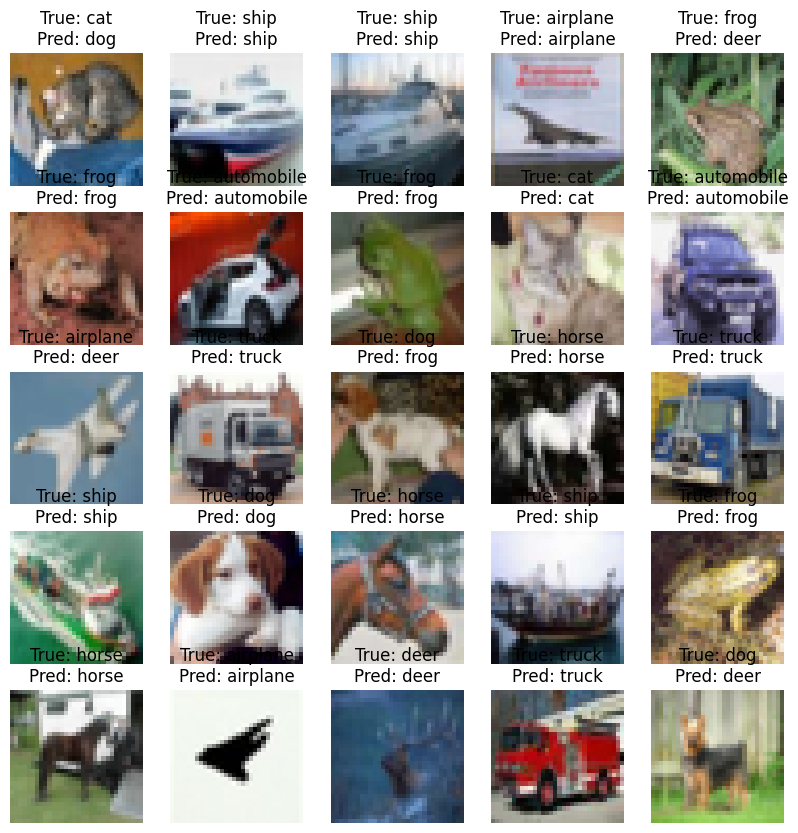

In [14]:
# Print een batch van testafbeeldingen en hun voorspellingen
def plot_images(images, labels, predictions, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i]/255.0)
        plt.title(f'True: {class_names[labels[i][0]]}\nPred: {class_names[np.argmax(predictions[i])]}')
        plt.axis('off')
    plt.show()

# CIFAR-10 klasse namen
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot een batch van testafbeeldingen
plot_images(x_test[:25], y_test[:25], predictions[:25], class_names)